# Windspeed Scraper for Wind Production Forecasting
This code is used to collect time-series windspeed data from the weather site Darksky.net for predicting wind farm power production. Historical weather data pages are accessed with latitude-longitude coordinates and dates of interest and contain time series graphs of weather parameters. The get_wsp function uses selenium to automate clicking along the slider bar, collecting windspeed values at hourly increments.

To collect new data you will need to do the following steps:
1. <a href='#date_range'>Set the date range you want new data over</a>
3. <a href='#download_data'>Download data</a>
4. <a href='#save_data'>Save the data</a>

**CAUTION:** the get_wsp function automates a clicking sequence, so all mouse activity should be halted while the script is running. It also quite slow, so it is best run overnight if collecting more than a few days of data. 

### Imports

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys
from selenium.webdriver import ActionChains

import time
import datetime

#### Darksky Scraper Function

In [41]:
def get_wsp(driver,lat,lon,dat,ticks):
    driver.get(f'https://darksky.net/details/{lat},{lon}/{dat}/us12/en')
    wind = []
    for tick in ticks:
        hour = driver.find_element_by_xpath(f'//span[{tick}]')
        ActionChains(driver).move_to_element(hour).click(hour).perform()
        nums = driver.find_elements_by_class_name('num')
        try:
            wind.append(int(nums[3].text))  # use 3 for wind, 5 for humidity
        except:
            if len(wind) >= 1:
                wind.append(wind[-1])
            else:
                wind.append(0)
    return wind

#### HTML grid features to click on

In [42]:
ticks1 = [
    '@class="even first" and @style="left: 0px;"',
    '@class="odd second" and @style="left: 33.3333px;"',
    '@class="even" and @style="left: 66.6667px;"',
    '@class="odd" and @style="left: 100px;"',
    '@class="even" and @style="left: 133.333px;"',
    '@class="odd" and @style="left: 166.667px;"',
    '@class="even" and @style="left: 200px;"',
    '@class="odd" and @style="left: 233.333px;"',
    '@class="even" and @style="left: 266.667px;"',
    '@class="odd" and @style="left: 300px;"',
    '@class="even" and @style="left: 333.333px;"',
    '@class="odd" and @style="left: 366.667px;"',
    '@class="even" and @style="left: 400px;"',
    '@class="odd" and @style="left: 433.333px;"',
    '@class="even" and @style="left: 466.667px;"',
    '@class="odd" and @style="left: 500px;"',
    '@class="even" and @style="left: 533.333px;"',
    '@class="odd" and @style="left: 566.667px;"',
    '@class="even" and @style="left: 600px;"',
    '@class="odd" and @style="left: 633.333px;"',
    '@class="even" and @style="left: 666.667px;"',
    '@class="odd" and @style="left: 700px;"',
    '@class="even" and @style="left: 733.333px;"',
    '@class="odd" and @style="left: 766.667px;"',
]

ticks2 = [
    '@class="even first" and @style="left: 0px;"',
    '@class="odd second" and @style="left: 34.7826px;"',
    '@class="even" and @style="left: 69.5652px;"',
    '@class="odd" and @style="left: 104.348px;"',
    '@class="even" and @style="left: 139.13px;"',
    '@class="odd" and @style="left: 173.913px;"',
    '@class="even" and @style="left: 208.696px;"',
    '@class="odd" and @style="left: 243.478px;"',
    '@class="even" and @style="left: 278.261px;"',
    '@class="odd" and @style="left: 313.043px;"',
    '@class="even" and @style="left: 347.826px;"',
    '@class="odd" and @style="left: 382.609px;"',
    '@class="even" and @style="left: 417.391px;"',
    '@class="odd" and @style="left: 452.174px;"',
    '@class="even" and @style="left: 486.957px;"',
    '@class="odd" and @style="left: 521.739px;"',
    '@class="even" and @style="left: 556.522px;"',
    '@class="odd" and @style="left: 591.304px;"',
    '@class="even" and @style="left: 626.087px;"',
    '@class="odd" and @style="left: 660.87px;"',
    '@class="even" and @style="left: 695.652px;"',
    '@class="odd" and @style="left: 730.435px;"',
    '@class="even" and @style="left: 765.217px;"',
]

### Read in wind farm cluster locations

In [43]:
plants = pd.read_csv('../datasets/wind_clusters.csv')
print(plants.shape)
plants.head(3)

(7, 3)


,Longitude,Latitude,MW
0,-118.320799,35.062432,3526.14
1,-121.736003,37.920458,1657.66
2,-116.606149,33.918124,687.85


<a id='date_range'></a>

### Define date range to collect data over

In [44]:
##### EDIT THIS CELL ######

# Set starting and ending dates
early_date = '06/07/2020'
later_date = '06/08/2020'

dates = pd.date_range(early_date, later_date).tolist()
dates = [date.strftime("%Y-%m-%d") for date in dates]

<a id='download_data'></a>

### Collect Data

In [45]:
#### RUN THIS CELL ######
ts1 = time.time()
st1 = datetime.datetime.fromtimestamp(ts1).strftime('%Y-%m-%d %H:%M:%S')
print(st1)


driver = webdriver.Chrome(ChromeDriverManager().install())

df_list = []

# To safely test, change to range 1 and just get first station
for i in range(1):  #plants.shape[0]
    
    pid = plants.index[i]
    lat = plants['Latitude'][i]
    lon = plants['Longitude'][i]
    
    wsp_list = []
    hr_list = []
    
    for date in dates:
        try:
            nu_wsp = get_wsp(driver,str(lat),str(lon),date,ticks1)
            hours = pd.date_range(start=date+' 00:00:00',end=date+' 23:00:00', periods=24)
            wsp_list.extend(nu_wsp)
            hr_list.extend(hours)
        except:
            try:
            
                time.sleep(5)
                nu_wsp = get_wsp(driver,str(lat),str(lon),date,ticks1)
                hours = pd.date_range(start=date+' 00:00:00',end=date+' 23:00:00', periods=24)
                wsp_list.extend(nu_wsp)
                hr_list.extend(hours)
            
            except:
            
                time.sleep(5)
                nu_wsp = get_wsp(driver,str(lat),str(lon),date,ticks2)
                hours = pd.date_range(start=date+' 01:00:00',end=date+' 23:00:00', periods=23)
                wsp_list.extend(nu_wsp)
                hr_list.extend(hours)
            
    nu_df = pd.DataFrame({'date':hr_list,pid:wsp_list})

    if i == 0:
        all_df = nu_df.copy()
    else:
        all_df = all_df.merge(nu_df,how='outer',on='date')

##### PRINT FINAL TIME STAMP #######
ts2 = time.time()
st2 = datetime.datetime.fromtimestamp(ts2).strftime('%Y-%m-%d %H:%M:%S')
print(st2)
print('t(s) = ' + str(ts2-ts1))
print('t(m) = ' + str((ts2-ts1)/60))

2020-06-08 16:45:09


[WDM] - Current google-chrome version 83.0.4103


[WDM] - Trying to download new driver from http://chromedriver.storage.googleapis.com/83.0.4103.39/chromedriver_mac64.zip
[WDM] - Unpack archive /Users/Sam/.wdm/drivers/chromedriver/83.0.4103.39/mac64/chromedriver.zip


2020-06-08 16:45:48
t(s) = 39.74956011772156
t(m) = 0.6624926686286926


### Inspect Data

In [35]:
print(all_df.shape)
all_df.head()

(864, 8)


,date,0,1,2,3,4,5,6
0,2020-04-16 00:00:00,14,7,15,4,8,4,14
1,2020-04-16 01:00:00,15,7,15,5,8,5,14
2,2020-04-16 02:00:00,13,5,15,7,8,7,13
3,2020-04-16 03:00:00,16,5,17,5,8,8,13
4,2020-04-16 04:00:00,12,4,17,6,8,8,14


Text(0.5, 0, '04/16/2020 - 05/21/2020')

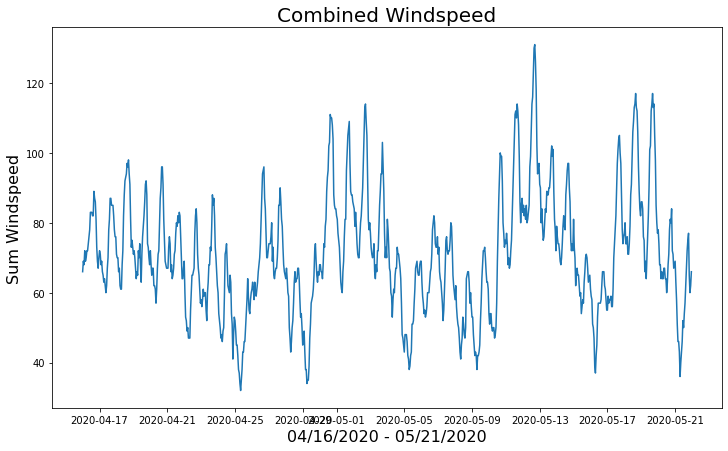

In [36]:
plt.figure(figsize=(12,7))
plt.plot(all_df['date'],all_df.sum(axis=1))
plt.title('Combined Windspeed',fontsize=20)
plt.ylabel('Sum Windspeed',fontsize=16)
plt.xlabel(early_date+' - '+later_date,fontsize=16)

<a id='save_data'></a>

### Save raw UV data to file

In [37]:
# Choose filename
sample_filename1 = 'nu_wsp'

all_df.to_csv('../datasets/time_series/'+sample_filename1+'.csv',index=False)

### Save production weighted UV data to file

In [38]:
# Choose filename
sample_filename2 = 'nu_wsp_output'

wsp_output = all_df.copy()

# Multiply UV index by total cluster capacity
for col in all_df.columns:
    if col != 'date':
        wsp_output[col] = all_df[col]*plants['MW'][int(col)]


wsp_output.to_csv('../datasets/time_series/'+sample_filename2+'.csv',index=False)